Copyright 2023 Google LLC

Use of this source code is governed by an MIT-style
license that can be found in the LICENSE file or at
https://opensource.org/licenses/MIT.

# Instructions
Please run the following cells sequentially
1. (Optional) Running 1b adds semantic labels and requires addtional resources (default to a second GPU).
* The function relies on an additonal image captioning model, e.g., BLIP.  
* The labels are nouns, extracted from the generated caption. 
* It merge masks sharing the same label. 
2. Add your own image and update ``image_path`` variable. 
3. Feel free to play with DiffSeg hyper-parameters such as the ``KL_THRESHOLD``.

# Import

In [2]:
import tensorflow as tf
from PIL import Image
import nltk
from transformers import AutoProcessor, TFBlipForConditionalGeneration
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from third_party.keras_cv.stable_diffusion import StableDiffusion 
from third_party.keras_cv.diffusion_model import SpatialTransformer
from diffseg.utils import process_image, augmenter, vis_without_label, semantic_mask
from diffseg.segmentor import DiffSeg

is_noun = lambda pos: pos[:2] == 'NN'
!nvidia-smi
nltk.download('all')

2025-04-03 08:57:28.831704: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 08:57:28.866250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 08:57:28.866281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 08:57:28.866305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 08:57:28.873386: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


/home/angus/anaconda3/envs/diffseg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-03 08:57:32.496562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20847 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:2b:00.0, compute capability: 8.6
2025-04-03 08:57:32.498179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20847 MB memory:  -> device: 1, name: NVIDIA A10, pci bus id: 0000:84:00.0, compute capability: 8.6
2025-04-03 08:57:32.499548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 20847 MB memory:  -> device: 2, name: NVIDIA A10, pci bus id: 0000:a2:00.0, comput

Thu Apr  3 08:57:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:2B:00.0 Off |                    0 |
|  0%   41C    P0             54W /  150W |   21083MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/angus/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/angus/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/angus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/angus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/angus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]   

True

# 1. Initialize SD Model

In [3]:
# Inialize Stable Diffusion Model on GPU:0 
with tf.device('/GPU:2'):
  image_encoder = ImageEncoder()
  vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-1].output,
        )
  model = StableDiffusion(img_width=512, img_height=512)
blip = None

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# 1b. Initialize BLIP (optional)

In [4]:
# Optionally initalize a BLIP captioning model on GPU:1
with tf.device('/GPU:3'):
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

2025-04-03 08:57:40.068086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


# 2. Run Inference on Real Images

In [5]:
# The first time running this cell will be slow
# because the model needs to download and loads pre-trained weights.
image_path = "/home/angus/uce_images/1003/img.jpg" # Specify the path to your image

if blip is not None:
  with tf.device('/GPU:3'):
    inputs = processor(images=Image.open(image_path), return_tensors="tf")
    out = blip.generate(**inputs)
    prompt = processor.decode(out[0], skip_special_tokens=True)
    print(prompt)
else:
  prompt = None

with tf.device('/GPU:2'):
  images = process_image(image_path)
  images = augmenter(images)
  latent = vae(tf.expand_dims(images, axis=0), training=False)
  images, weight_64, weight_32, weight_16, weight_8, x_weights_64, x_weights_32, x_weights_16, x_weights_8 = model.text_to_image(
    prompt,
    batch_size=1,
    latent=latent,
    timestep=300
  )
  

/home/angus/anaconda3/envs/diffseg/lib/python3.9/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a cup of coffee


2025-04-03 08:57:45.873753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


# 3. Generate Segementation Masks

(512, 512)



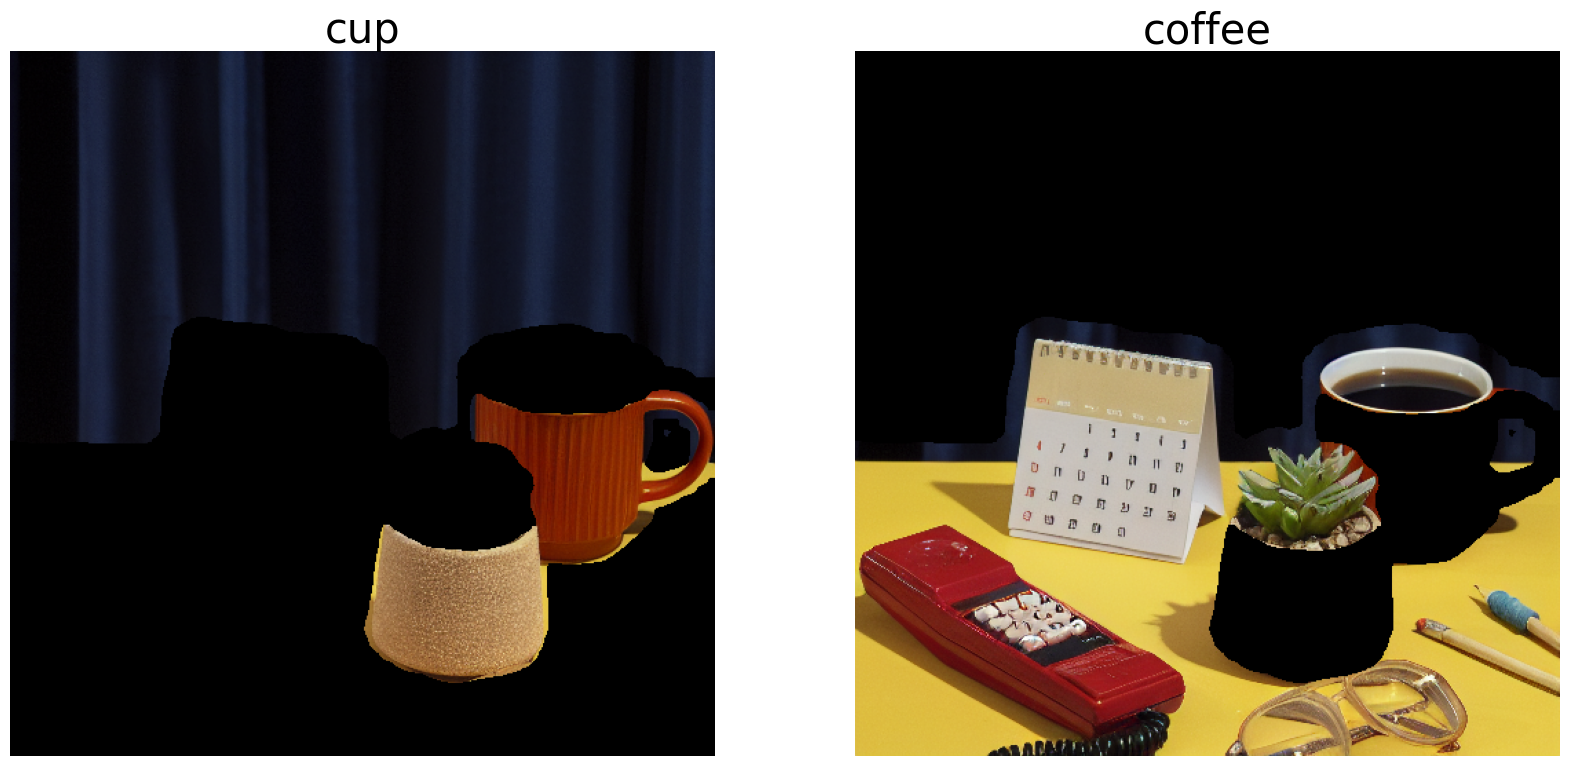

In [6]:
KL_THRESHOLD = [0.9]*3 # KL_THRESHOLD controls the merging threshold
NUM_POINTS = 16
REFINEMENT = True

from diffseg.utils import vis_without_label
with tf.device('/GPU:2'):
  segmentor = DiffSeg(KL_THRESHOLD, REFINEMENT, NUM_POINTS)
  pred = segmentor.segment(weight_64, weight_32, weight_16, weight_8) # b x 512 x 512
  if blip is not None:
    tokenized = nltk.word_tokenize(prompt)
    nouns = [(i,word) for i,(word, pos) in enumerate(nltk.pos_tag(tokenized)) if is_noun(pos)] 

  for i in range(len(images)):
    if blip is not None:
      x_weight = segmentor.aggregate_x_weights([x_weights_64[i],x_weights_32[i], x_weights_16[i], x_weights_8[i]],weight_ratio=[1.0,1.0,1.0,1.0])
      label_to_mask = segmentor.get_semantics(pred[i], x_weight[i], nouns,voting="mean")
      semantic_mask(images[i], pred[i], label_to_mask)
    print(pred[i].shape)
    print()
    vis_without_label(pred[i],images[i],save=True,dir="./results",index=i,num_class=len(set(pred[i].flatten())))